# Analyze results of simulated transition

In [1]:
"""Further command line arguments:
        c       script will close all open plots
        sli     data of the original simulation written in sli will be analyzed. 
                Note that at this point, the data must be of the same simulation type, 
                as specifications are loaded from .npy-files of the pynest simulation. 

    Overview over all populations: Raster plot, mean rates, mean CV of ISI per population.
"""
from imp import reload
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sys, os
import time
sys.path.append(os.path.abspath('../')) # include path with style
sys.path.append(os.path.abspath('../trans_simulation/')) # include path with simulation specifications
import style; reload(style)
# Close other plots by adding 'c' after 'run <script>' 
if 'c' in sys.argv:
    plt.close('all')
picture_format = '.pdf'
######################################################
# Import specific moduls
import network_params_trans; reload(network_params_trans)
import user_params_trans as user; reload(user)
%matplotlib inline

xfactor = 2
style.rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83) 

reverse_order = True # do analysis such that plots resemble those of the paper (starting with L6i)
plotting = True

def enum(arr1, *args):
    i_range = range(len(arr1))
    return zip(i_range, arr1 ,*args)

def print_perc(i, i_total):
    i_perc = round(100 * i / i_total)
    print("%i"%(i_perc), end="\r")

In [2]:
# DATA
data_path = user.data_dir

sim_spec = "a0.1_t0.6"

file_name  = sim_spec + ".hdf5"  
data_file = h5py.File(os.path.join(data_path, file_name), "r")

area    = data_file.attrs["area"]   
t_sim   = data_file.attrs["t_sim"]  
t_trans = data_file.attrs["t_trans"]
dt      = data_file.attrs["dt"]    
populations   = data_file.attrs["populations"].astype("|U4")
layers        = data_file.attrs["layers"].astype("|U4")        
types         = data_file.attrs["types"].astype("|U4")     
n_populations = data_file.attrs["n_populations"]
n_layers      = data_file.attrs["n_layers"]       
n_types       = data_file.attrs["n_types"] 

t_measure = t_sim - t_trans

# labels & colors: need to be adapted if n_types != (e, i)
layer_colors = style.colors[:n_layers]
colors = np.array([color for color in layer_colors for i in range(n_types)])
colors[1::2] = colors[1::2] * 0.4   #### adapt for more than two types!
if reverse_order:
    populations = populations[::-1]
    layers = layers[::-1]
    types = types[::-1]
    colors = colors[::-1]

d0.00_j1.00_sdJ0.00
[ 454.  454.  454.  454.  454.  454.  454.  454.]
[ 0.  0.  0.  0.  0.  0.  0.  0.]
L6i
L6e
L5i
L5e
L4i
L4e
L23i
L23e
d0.10_j1.00_sdJ0.00
[ 67.31034483  52.29166667  51.45454545  71.20833333  66.          32.1369863
  17.96551724   4.38647343]
[ 17.90608344  17.37649874  12.53622849  18.41529972  21.21406052
  14.52817926  10.2148734    5.65731629]
L6i
L6e
L5i
L5e
L4i
L4e
L23i
L23e
d0.20_j1.00_sdJ0.00
[ 34.27586207  22.69444444  32.18181818  42.625       34.32727273
  15.33333333   8.4137931    0.74396135]
[  8.57782446   8.52225663  10.5297689    8.70015565  12.12518723
   7.87652041   5.81031925   1.6112976 ]
L6i
L6e
L5i
L5e
L4i
L4e
L23i
L23e
d0.30_j1.00_sdJ0.00
[ 24.34482759  13.65277778  20.72727273  30.875       27.92727273
  10.23744292   6.82758621   0.16425121]
[  9.2932154    6.60105152   5.98621005   8.01983219  10.52072335
   6.08750984   4.37917458   0.61548245]
L6i
L6e
L5i
L5e
L4i
L4e
L23i
L23e
d0.40_j1.00_sdJ0.00
[ 16.96551724   8.25        16.54545455

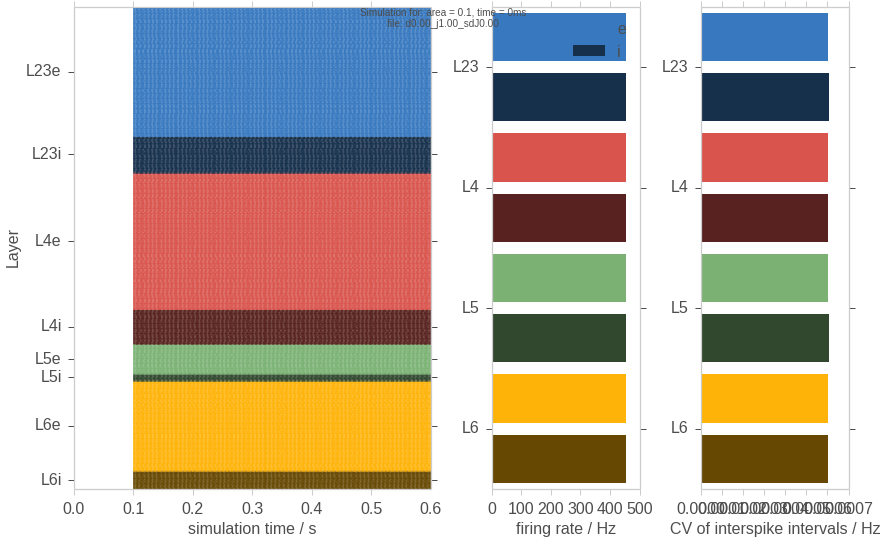

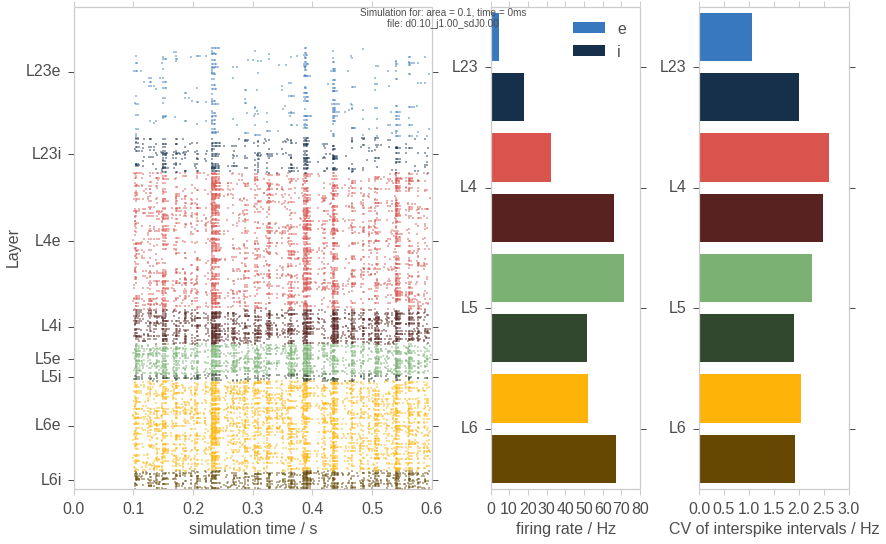

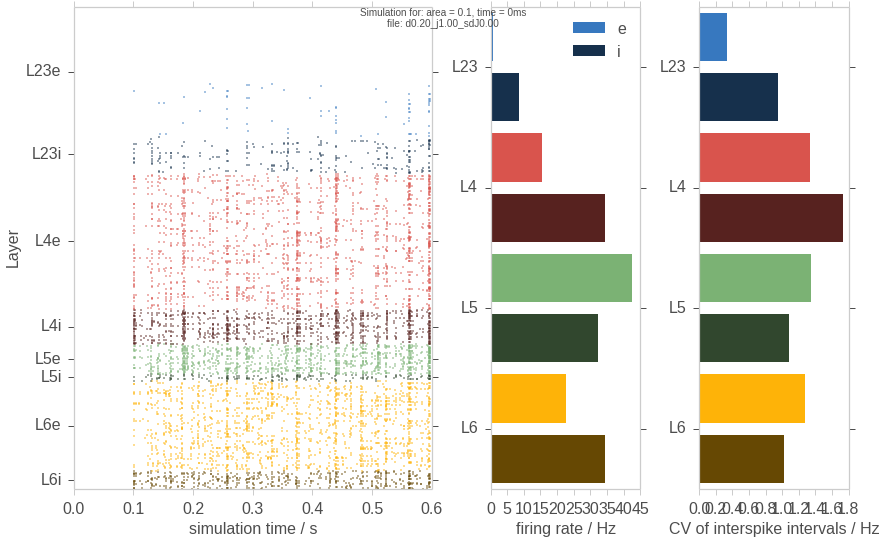

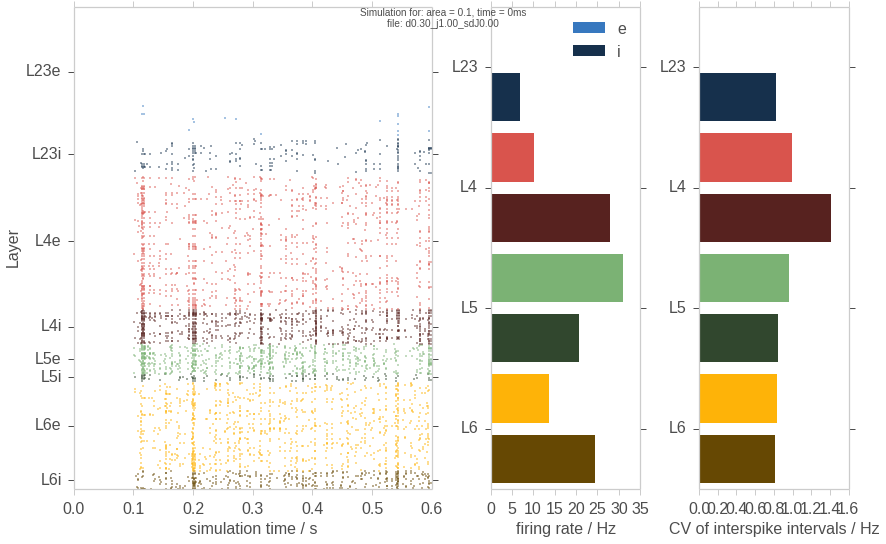

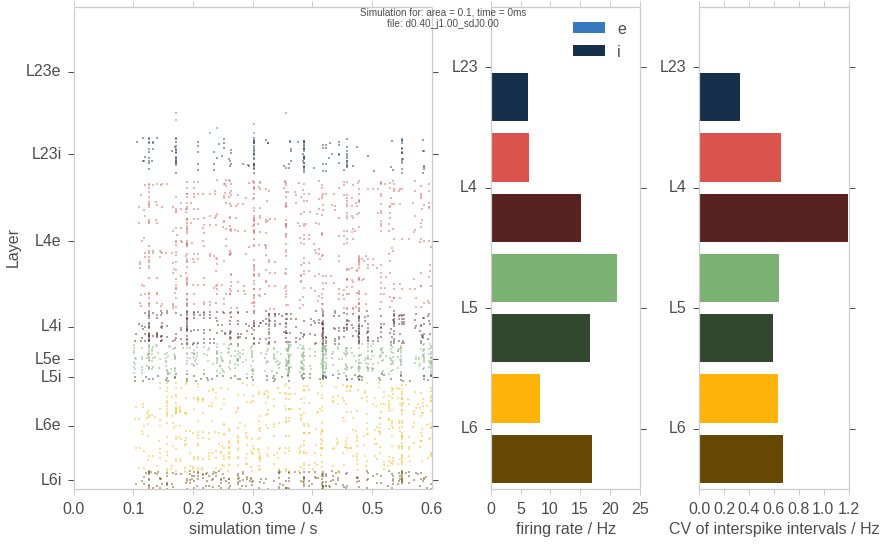

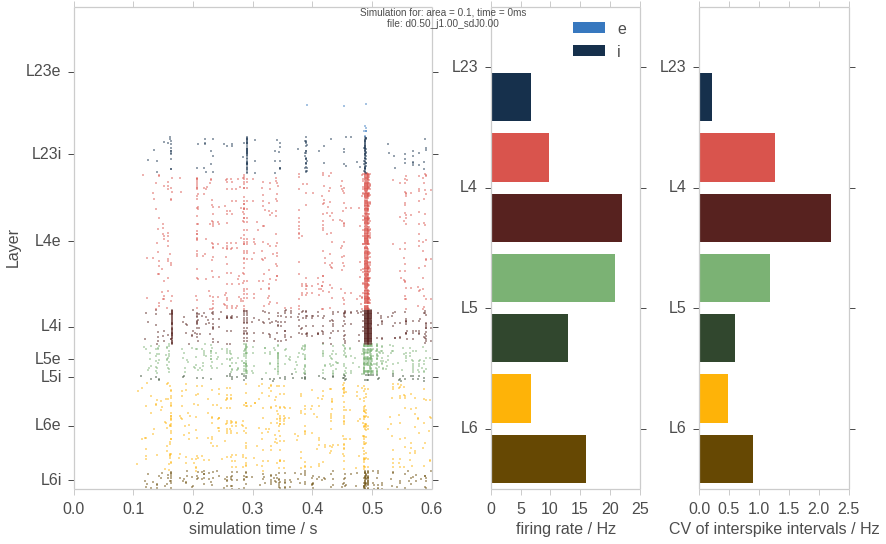

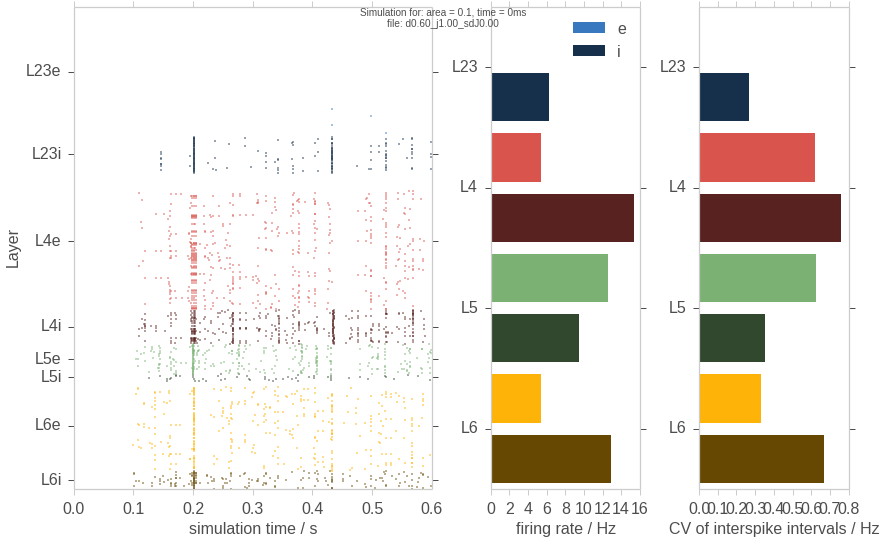

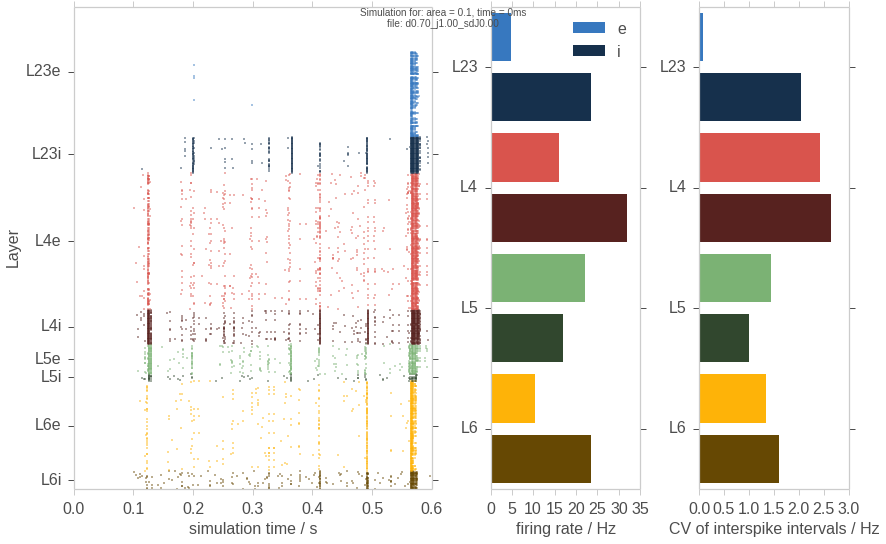

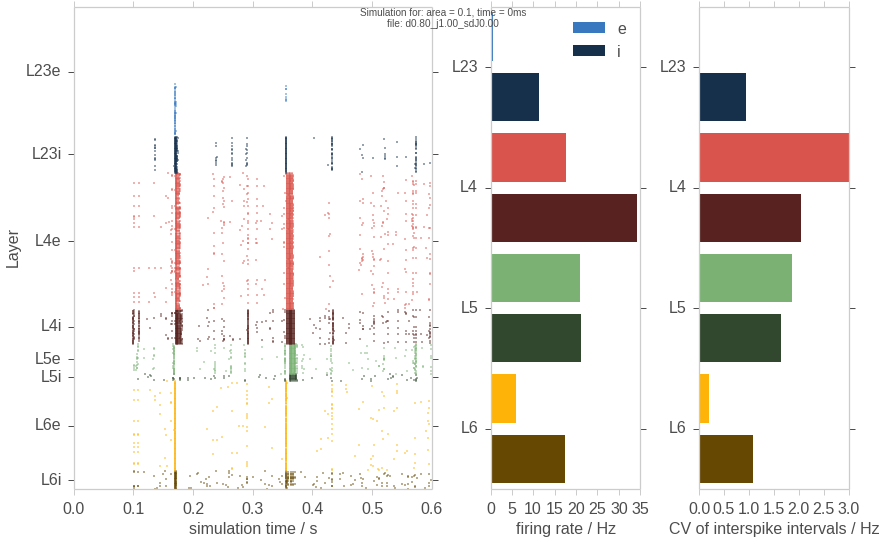

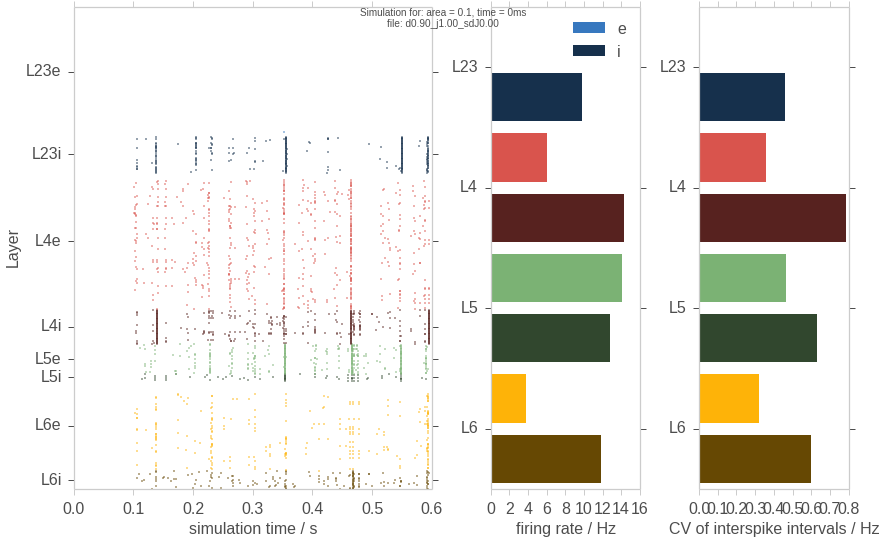

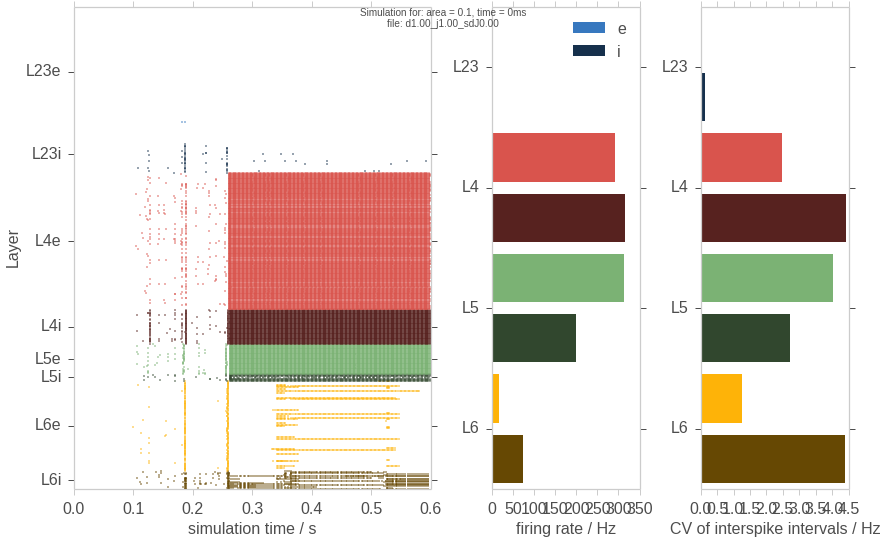

In [18]:
# Analyze spikes
for sim_spec2 in data_file.keys():
    print(sim_spec2)
    grp = data_file[sim_spec2 + "/spikes"]
    dt = grp.attrs["dt"]
    n_neurons_rec_spike = grp.attrs["n_neurons_rec_spike"][:]
    if reverse_order:
        n_neurons_rec_spike = n_neurons_rec_spike[::-1]
    offsets = np.append([0], np.cumsum(n_neurons_rec_spike))
    # set yticks to center of recorded n spikes of one layer
    yticks = (offsets[1:] - offsets[:-1]) * 0.5 + offsets[:-1]
    
    
    neuron_ids_all = []
    times_all = []
    rates_all = []
    # Mean and Std of firing rates and CV of ISI
    rates_mean  = np.zeros(n_populations)
    rates_std   = np.zeros(n_populations)
    cv_isi_mean = np.zeros(n_populations)
    cv_isi_std  = np.zeros(n_populations)
    no_isi = []
    
    for i, population in enumerate(populations):
        neuron_ids_all.append([])
        times_all.append([])
        # Get data
        subgrp = grp[str(population)]
        raw_times_all   = subgrp["times"][:] * dt * 1e-3
        indices         = subgrp["rec_neuron_i"][:]
        
        # Firing rate:
        n_spikes = np.diff(indices)
        rates = n_spikes / t_measure # Hz
        
        cv_isi_all = np.empty(0)
    
        rates = []
        for j in range(len(indices) - 1):
            times = raw_times_all[indices[j]:indices[j+1]]
            times = times[times > t_trans]
            n_spikes = len(times)
    
            if n_spikes > 1:
                isi = np.diff(times)
                mean_isi = np.mean(isi)
                var_isi = np.var(isi)
                cv_isi = var_isi / mean_isi**2
                cv_isi_all = np.append(cv_isi_all, cv_isi)
            else:
                no_isi.append(str(population) + '_' + str(j))
            
            times_all[i].append(times)
            neuron_ids_all[i].append([j]*n_spikes + offsets[i])
            rates.append(n_spikes / t_measure)
    
        # Means
        rates_mean[i] = np.mean(rates)
        rates_std[i] = np.std(rates)
        cv_isi_mean[i] = np.mean(cv_isi_all)
        cv_isi_std[i] = np.std(cv_isi_all)

            
    print(rates_mean)
    print(rates_std)
    
    fig = plt.figure()
    suptitle = 'Simulation for: area = %.1f, time = %ims'%(area, t_sim)
    suptitle += '\nfile: ' + sim_spec2
    
    fig.suptitle(suptitle, y=0.98)
    # Raster plot
    ax0 = plt.subplot2grid((1, 4), (0, 0), colspan=2, rowspan=1)
    # Rates
    ax1 = plt.subplot2grid((1, 4), (0, 2), colspan=1, rowspan=1)
    # CV of interspike interval (ISI)
    ax2 = plt.subplot2grid((1, 4), (0, 3), colspan=1, rowspan=1)
    
    y_mean = np.arange(n_populations) + 0.1
    bar_height = 0.8 
    for i, population in enumerate(populations):
        print(population)
        for times, neuron_ids in zip(times_all[i], neuron_ids_all[i]):
            ax0.plot(times, neuron_ids, '.', ms=3, color=colors[i], label=population)
        ax1.barh(y_mean[i], rates_mean[i], height=bar_height, color=colors[i], linewidth=0)
        ax2.barh(y_mean[i], cv_isi_mean[i], height=bar_height, color=colors[i], linewidth=0)
    
    ylim_mean = (0, n_populations)
    yticks_mean = np.arange(n_types * 0.5, n_populations, n_types)
    
    # Raster Plot
    xlim = (0, t_sim)
    ymax_raster = offsets[-1]
    ylim = (0, ymax_raster)
    ax0.set_yticks(yticks)
    ax0.set_yticklabels(populations)
    ax0.set_xlabel('simulation time / s')
    ax0.set_ylabel('Layer')
    ax0.set_xlim(*xlim)
    ax0.set_ylim(*ylim)
    ax0.grid(False)
    
    # Rates
    ax1.set_yticks(yticks_mean)
    ax1.set_yticklabels(layers)
    ax1.set_xlabel('firing rate / Hz')
    #ax1.set_ylabel('Layer')
    ax1.set_ylim(*ylim_mean)
    #ax1.set_xlim(0, 20)
    ax1.grid(False)
      
    # CV of ISI
    ax2.set_yticks(yticks_mean)
    ax2.set_yticklabels(layers)
    ax2.set_xlabel('CV of interspike intervals / Hz')
    #ax2.set_ylabel('Layer')
    ax2.set_ylim(*ylim_mean)
    #ax2.set_xlim(0, 20)
    ax2.grid(False)
    
    # Legend; order is reversed, such that labels appear correctly
    for i in range(n_types):
        ax1.barh(0, 0, 0, color=colors[-(i+1)], label=types[-(i+1)], linewidth=0)
    ax1.legend(loc='best')
    
    for ax in fig.axes:
        style.fixticks(ax)
    fig_name = 'rates_etc'
    
    #fig.savefig(figure_path + fig_name + picture_format):

In [4]:
# Analyze spikes
sim_spec2 = "d0.00_j1.00_sdJ0.00"

grp = data_file[sim_spec2 + "/spikes"]
dt = grp.attrs["dt"]
n_neurons_rec_spike = grp.attrs["n_neurons_rec_spike"][:]
if reverse_order:
    n_neurons_rec_spike = n_neurons_rec_spike[::-1]
offsets = np.append([0], np.cumsum(n_neurons_rec_spike))
# set yticks to center of recorded n spikes of one layer
yticks = (offsets[1:] - offsets[:-1]) * 0.5 + offsets[:-1]


neuron_ids_all = []
times_all = []
rates_all = []
# Mean and Std of firing rates and CV of ISI
rates_mean  = np.zeros(n_populations)
rates_std   = np.zeros(n_populations)
cv_isi_mean = np.zeros(n_populations)
cv_isi_std  = np.zeros(n_populations)
no_isi = []

for i, population in enumerate(populations):
    neuron_ids_all.append([])
    times_all.append([])
    # Get data
    subgrp = grp[str(population)]
    raw_times_all   = subgrp["times"][:] * dt * 1e-3
    indices         = subgrp["rec_neuron_i"][:]
    
    # Firing rate:
    n_spikes = np.diff(indices)
    rates = n_spikes / t_measure # Hz
    
    cv_isi_all = np.empty(0)

    rates = []
    for j in range(len(indices) - 1):
        times = raw_times_all[indices[j]:indices[j+1]]
        times = times[times > t_trans]
        n_spikes = len(times)

        if n_spikes > 1:
            isi = np.diff(times)
            mean_isi = np.mean(isi)
            var_isi = np.var(isi)
            cv_isi = var_isi / mean_isi**2
            cv_isi_all = np.append(cv_isi_all, cv_isi)
        else:
            no_isi.append(str(population) + '_' + str(j))
        
        times_all[i].append(times)
        neuron_ids_all[i].append([j]*n_spikes + offsets[i])
        rates.append(n_spikes / t_measure)

    # Means
    rates_mean[i] = np.mean(rates)
    rates_std[i] = np.std(rates)
    cv_isi_mean[i] = np.mean(cv_isi_all)
    cv_isi_std[i] = np.std(cv_isi_all)
    
print(rates_mean)
print(rates_std)

L6i
L6e
L5i
L5e
L4i
L4e
L23i
L23e


/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


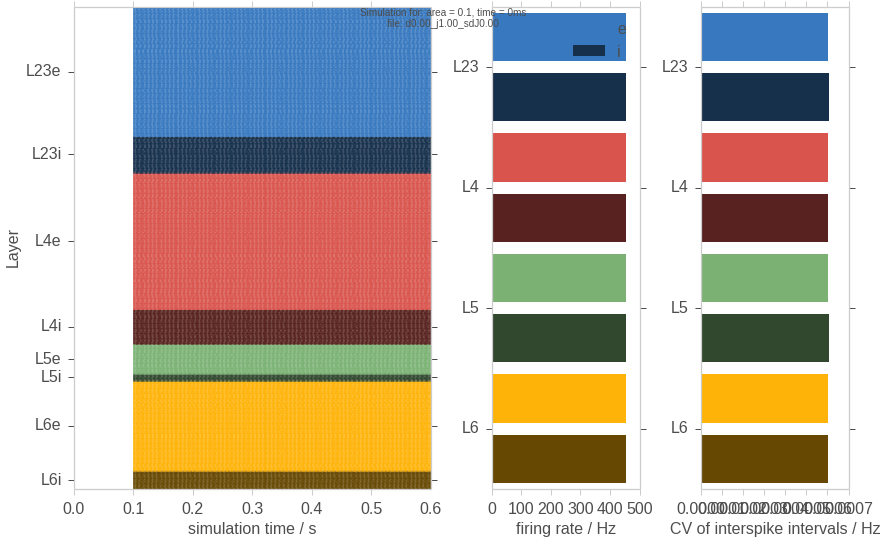

In [5]:
fig = plt.figure()
suptitle = 'Simulation for: area = %.1f, time = %ims'%(area, t_sim)
suptitle += '\nfile: ' + sim_spec2

fig.suptitle(suptitle, y=0.98)
# Raster plot
ax0 = plt.subplot2grid((1, 4), (0, 0), colspan=2, rowspan=1)
# Rates
ax1 = plt.subplot2grid((1, 4), (0, 2), colspan=1, rowspan=1)
# CV of interspike interval (ISI)
ax2 = plt.subplot2grid((1, 4), (0, 3), colspan=1, rowspan=1)

y_mean = np.arange(n_populations) + 0.1
bar_height = 0.8 
for i, population in enumerate(populations):
    print(population)
    for times, neuron_ids in zip(times_all[i], neuron_ids_all[i]):
        ax0.plot(times, neuron_ids, '.', ms=3, color=colors[i], label=population)
    ax1.barh(y_mean[i], rates_mean[i], height=bar_height, color=colors[i], linewidth=0)
    ax2.barh(y_mean[i], cv_isi_mean[i], height=bar_height, color=colors[i], linewidth=0)

ylim_mean = (0, n_populations)
yticks_mean = np.arange(n_types * 0.5, n_populations, n_types)

# Raster Plot
xlim = (0, t_sim)
ymax_raster = offsets[-1]
ylim = (0, ymax_raster)
ax0.set_yticks(yticks)
ax0.set_yticklabels(populations)
ax0.set_xlabel('simulation time / s')
ax0.set_ylabel('Layer')
ax0.set_xlim(*xlim)
ax0.set_ylim(*ylim)
ax0.grid(False)

# Rates
ax1.set_yticks(yticks_mean)
ax1.set_yticklabels(layers)
ax1.set_xlabel('firing rate / Hz')
#ax1.set_ylabel('Layer')
ax1.set_ylim(*ylim_mean)
#ax1.set_xlim(0, 20)
ax1.grid(False)
  
# CV of ISI
ax2.set_yticks(yticks_mean)
ax2.set_yticklabels(layers)
ax2.set_xlabel('CV of interspike intervals / Hz')
#ax2.set_ylabel('Layer')
ax2.set_ylim(*ylim_mean)
#ax2.set_xlim(0, 20)
ax2.grid(False)

# Legend; order is reversed, such that labels appear correctly
for i in range(n_types):
    ax1.barh(0, 0, 0, color=colors[-(i+1)], label=types[-(i+1)], linewidth=0)
ax1.legend(loc='best')

for ax in fig.axes:
    style.fixticks(ax)
fig_name = 'rates_etc'

#fig.savefig(figure_path + fig_name + picture_format)

In [6]:
print(rates_mean)
print(rates_std)

[ 454.  454.  454.  454.  454.  454.  454.  454.]
[ 0.  0.  0.  0.  0.  0.  0.  0.]


In [7]:
# Clear large varibales:
times_all = None
neurons_ids_all= None

# Theoretical predictions

In [8]:
"""mean_field_trans.py

Imports mf_trans and mf_plot.

Numerical analysis of the equations corresponding to the 
stationary solutions of the mean field approximation of the 
cortical microcircuit model. 

8 coupled integral equations are solved numerically. 
"""
from scipy.optimize import root
sys.path.append(os.path.abspath('../mean_field/')) # include path with mean field approximation
import mf_trans as model; reload(model)
import mf_micro as mf_micro; reload(mf_micro)
import mf_plot; reload(mf_plot)


# Global parameters
choose_model = "brunelA"  # brunelA, brunelB for corresponding models!
n_layer = 4
n_types = 2
n_pop = n_layer * n_types
print("Model: ", choose_model)
print("n layers: ", n_layer)
# Create reference instance containing parameters and functions:
# (used mostly for plotting)
mf_net0  = model.mf_net()
plot_pops= mf_net0.populations    # These populations are plotted
if not type(plot_pops) == np.ndarray:
    plot_pops = np.array([plot_pops])

Model:  brunelA
n layers:  4


In [9]:
######################################################
# Functions
######################################################
def cool_C_ab(v_guess_0, step_init = 0.01, d_step=0.5, tolerance=5, jacobian=False, root_method='hybr', options=None, vary_j02=False):
    """Iteratively change C_ab from C_B = Brunel's to C_M = microcircuit 
    on the straight line connecting C_B and C_M.
    If not disabled, j02 varied as well.
    Returns distances, v0s[distance, population], failures
    """
    print("Iterate over C_ab")
    # initiate
    g   = 4.
    j02_init = 1.
    j02 =   j02_init
    v_guess = v_guess_0
    C_B     = model.mf_net().C_ab
    distances   = []
    failures    = np.array([])
    mf_net = model.mf_net(g=g, j02=j02, C_ab=C_B)
    if jacobian:
        jac = mf_net.jacobian
    else:
        jac = False
    sol = root(mf_net.root_v0, v_guess, jac=jac, method=root_method, options=options)
    if sol["success"]:
        v0  = sol["x"]
        if np.all(v0 < 1./mf_net.t_ref): 
            v0s     = v0
            distances.append(0.)
            v_guess = v0
        else:       # converged unphysically (v0 >= 1/t_ref)
            raise Exception("Converged unphysically for v_guess_0")
    else:   
        raise Exception("No solution found for v_guess_0")
    # Define steps and matrices
    step    = step_init     # initial step size
    C_M     = mf_micro.mf_net().C_ab
    delta_C = C_M - C_B
    #delta_C[deltaC > 0] = 0     # only increasing
    #delta_C[:, 0::2] = 0        # only excitatory
    delta_j02    = 1.
    distance    = 0.
    n_fails = 0
    n_succ  = 0
    # Go on
    print("\t")
    while distance <= 1.:
        distance += step
        C_ab    = C_B + distance * delta_C
        if vary_j02:
            j02     = j02_init + distance * delta_j02
        mf_net  = model.mf_net(g=g, j02=j02, C_ab=C_ab)
        try:
            sol = root(mf_net.root_v0, v_guess, jac=jac, method=root_method, options=options)
            if sol["success"]:
                v0  = sol["x"]
                if np.all(v0 < 1./mf_net.t_ref): 
                    v0s = np.vstack((v0s, v0))
                    distances.append(distance)
                    v_guess = v0
                    n_fails = 0
                    n_succ  +=1
                    if n_succ >= tolerance and step < step_init:
                        print("succ\t%.5f\t%i %i"%(distance, n_succ, np.log(step)/np.log(d_step)))
                        step /= d_step
                else:       # converged unphysically (v0 >= 1/t_ref)
                    raise Exception("unphysical")
            else:   
                raise Exception("no solution")
        except: # no (good) solution found
            failures = np.append(failures, distance)
            if n_fails == 0:
                distances.pop()
                v0s = np.delete(v0s, -1, axis=0)
            n_fails += 1
            n_succ   = 0
            print("fail\t%.5f\t%i %i"%(distance, n_fails, np.log(step)/np.log(d_step)))
            distance = distances[-1]
            step    *= d_step
            if n_fails >= tolerance:
                print("Tolerance exceeded at distance = %.3f"%distance)
                break
    distances = np.array(distances)
    return(distances, v0s, failures, C_ab, C_M, step)     


def diagnostics(log):
    """Currently not working"""
    successes       = np.sum(log ==  1) # converged successful     
    nots            = np.sum(log ==  0) # after break
    failures        = np.sum(log == -1) # algorithm stopped unsuccessfull
    exceptions      = np.sum(log == -2) # algorithm yielded NaN/overflow
    unphysicals     = np.sum(log == -3) # converged unphysically (v0 > 1/t_ref)
    print("%i\t%i\t%i\t%i\t%i"%(successes, nots, failures, exceptions, unphysicals))

In [10]:
######################################################
# Solving
######################################################
jacobian        = False     # whether to use calculated jacobian
root_method     = ['hybr', 'lm', 'broyden1', 'anderson', 'krylov'][0]
print("Method: ", root_method)
options         = None
vary_j02 = False

plotting = True
iterate_g = False              # iterate g for fixed v_ext
iterate_j02 = False             # iterate j02 for g=4
iterate_C = False

iterate_C = True
if iterate_C:
    v_guess0    = np.array([131, 127, 147, 141, 144, 141, 172, 147])
    d_step      = 0.1   # ratio by which step is reduced
    step_init   = d_step**3  # initial step size
    tolerance   = 10     # number of fails accepted at one distance
    t_int0      = time.time()
    dists, v0s, fails, C_ab, C_M, final_step  = cool_C_ab(v_guess0, step_init, d_step, tolerance, jacobian, root_method, options, vary_j02)
    t_int1      = time.time() - t_int0
    print("Integration time: %.2f"%(t_int1))

if iterate_g:
    v_guess0 = np.array([2.]*n_pop)  # initial guess
    gs        = np.arange(10., 4., -0.1)
    #v_guess0 = np.array([131, 127, 147, 141, 144, 141, 172, 147])
    #gs        = np.array([4.])

    t_int0      = time.time()
    v0s, log  = v0_g(v_guess0, gs, jacobian, root_method, options)
    t_int1      = time.time() - t_int0
    print("Integration time: %.2f"%(t_int1))
    print("succ.\tnots\tfail\texcept\tv >= 500 Hz")
    diagnostics(log)
    
# iterate J for g = 4.
if iterate_j02:
    v_guess0    = np.array([131, 127, 147, 141, 144, 141, 172, 147])
    j02s        = np.arange(1, 2.0, 0.001)

    t_int0      = time.time()
    v0s, log    = v0_j02(v_guess0, j02s, jacobian, root_method, options)
    t_int1      = time.time() - t_int0
    print("Integration time: %.2f"%(t_int1))
    print("succ.\tnots\tfail\texcept\tv >= 500 Hz")
    diagnostics(log)

/usr/lib/python3/dist-packages/scipy/integrate/quadpack.py:295: UserWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg)
/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:236: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Method:  hybr
Iterate over C_ab
	
fail	0.38900	1 3
fail	0.38760	1 4
fail	0.38741	2 5
fail	0.38740	3 6
fail	0.38740	4 7
fail	0.38740	5 8
fail	0.38740	6 9
fail	0.38740	7 10
fail	0.38740	8 11
fail	0.38740	9 12
fail	0.38740	10 13
Tolerance exceeded at distance = 0.387
Integration time: 43.74


/usr/lib/python3/dist-packages/scipy/integrate/quadpack.py:295: UserWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg)


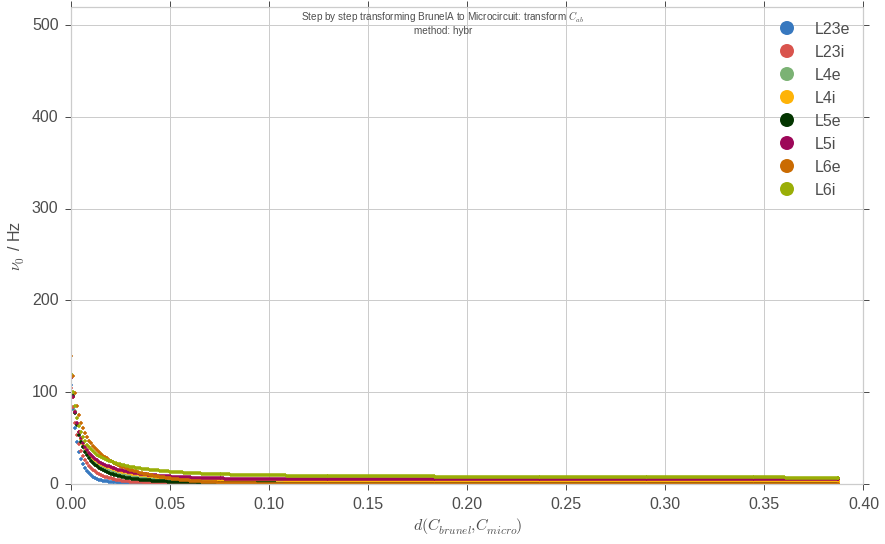

In [11]:
######################################################
# Plotting
######################################################
if plotting:
    if iterate_C:
        suptitle = "Step by step transforming BrunelA to Microcircuit: transform $C_{ab}$" + \
            "\nmethod: " + root_method
    if iterate_j02:
        suptitle = "Step by step transforming BrunelA to Microcircuit: transform $J_{L23e, L4e}$" + \
            "\nmethod: " + root_method
    plot = mf_plot.mf_plot(mf_net0, suptitle, plot_pops) 

    if iterate_C:
        plot.plot_transform(dists, v0s, xlabel="$d(C_{brunel}, C_{micro})$")
    
    if iterate_g:
        plot.plot_transform(gs, v0s, xlabel="$g$")
    
    if iterate_j02:
        plot.plot_transform(j02s, v0s, xlabel="$\\frac{J_{L23e, L4e}}{J}$")
    

    fig_name = 'mean_field_v0'
    #plot.fig.savefig(figure_path + fig_name + picture_format)